### Import packages

In [3]:
# Common data handling libraries
import os
import string
import pandas as pd
import numpy as np
import glob
import pickle

# Gensim for LDA
import gensim

# NLTK for test processing
import nltk
nltk.download('stopwords')

# spacy for Lemmatization
import spacy

# Visualization
import matplotlib.pyplot as plt

# Deep learning modeling
import keras

# Model evaluation metrics
import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jsaikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


### Loading Dataset

In [10]:
with open("./data/Flickr8k_text/Flickr8k.token.txt", 'r') as file:
    #Read the file data
    data = file.read()

image_id_list, caption_list = list(), list()
    
# Create a list of all image names in the directory
img_file_names_list = glob.glob('./data/Flicker8k_Dataset/' + '*.jpg')
img_file_names_list = [img_file.replace('\\','/') for img_file in img_file_names_list]    

#iterate through each line
for line in data.split('\n'):
    #line is empty continue with next line
    if len(line) < 2:
        continue

    #split the imageid and caption sep by tab
    image_id, caption = line.split('\t')

    #strip the file extension from imageid
    image_id = image_id.split('#')[0]

    #append the file path to image_id 
    image_id = os.path.join("./data/Flicker8k_Dataset/", image_id)
    
    if image_id in img_file_names_list:
        #store it in list
        image_id_list.append(image_id)
        caption_list.append(caption)
        
    
img_cap_df = pd.DataFrame({'image_id':image_id_list, 'caption':caption_list})

# Group the captions by image_id to form a single sentence for each image
img_cap_df = img_cap_df.groupby('image_id')['caption'].apply(lambda x : ' '.join(x)).reset_index(name='caption')

img_cap_df.head()

,image_id,caption
0,./data/Flicker8k_Dataset/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...
1,./data/Flicker8k_Dataset/1001773457_577c3a7d70...,A black dog and a spotted dog are fighting A b...
2,./data/Flicker8k_Dataset/1002674143_1b742ab4b8...,A little girl covered in paint sits in front o...
3,./data/Flicker8k_Dataset/1003163366_44323f5815...,A man lays on a bench while his dog sits by hi...
4,./data/Flicker8k_Dataset/1007129816_e794419615...,A man in an orange hat starring at something ....


In [18]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

img_cap_df.head()

,image_id,caption
0,./data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .
1,./data/Flicker8k_Dataset/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .
2,./data/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . A little girl is sitting in front of a large painted rainbow . A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . There is a girl with pigtails sitting in front of a rainbow painting . Young girl with pigtails painting outside in the grass .
3,./data/Flicker8k_Dataset/1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him . A man lays on the bench to which a white dog is also tied . a man sleeping on a bench outside with a white and black dog sitting next to him . A shirtless man lies on a park bench with his dog . man laying on bench holding leash of dog sitting on ground
4,./data/Flicker8k_Dataset/1007129816_e794419615.jpg,A man in an orange hat starring at something . A man wears an orange hat and glasses . A man with gauges and glasses is wearing a Blitz hat . A man with glasses is wearing a beer can crocheted hat . The man with pierced ears is wearing glasses and an orange hat .


### Data Cleaning

In [3]:
def clean_text(data):

    # convert to lower case
    data = [word.lower() for word in data.split()]
    
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # remove punctuation from each word
    data = [word.translate(table) for word in data]
    
    # remove tokens with numbers in them
    data = [word for word in data if word.isalpha()]   
    
    # remove stopwords
    data = [word for word in data if word not in nltk.corpus.stopwords.words('english')]
    
    return data


data_caption = list(img_cap_df['caption'].apply(lambda x : clean_text(x)))
data_caption[:5]

[['child',
  'pink',
  'dress',
  'climbing',
  'set',
  'stairs',
  'entry',
  'way',
  'girl',
  'going',
  'wooden',
  'building',
  'little',
  'girl',
  'climbing',
  'wooden',
  'playhouse',
  'little',
  'girl',
  'climbing',
  'stairs',
  'playhouse',
  'little',
  'girl',
  'pink',
  'dress',
  'going',
  'wooden',
  'cabin'],
 ['black',
  'dog',
  'spotted',
  'dog',
  'fighting',
  'black',
  'dog',
  'tricolored',
  'dog',
  'playing',
  'road',
  'black',
  'dog',
  'white',
  'dog',
  'brown',
  'spots',
  'staring',
  'street',
  'two',
  'dogs',
  'different',
  'breeds',
  'looking',
  'road',
  'two',
  'dogs',
  'pavement',
  'moving',
  'toward'],
 ['little',
  'girl',
  'covered',
  'paint',
  'sits',
  'front',
  'painted',
  'rainbow',
  'hands',
  'bowl',
  'little',
  'girl',
  'sitting',
  'front',
  'large',
  'painted',
  'rainbow',
  'small',
  'girl',
  'grass',
  'plays',
  'fingerpaints',
  'front',
  'white',
  'canvas',
  'rainbow',
  'girl',
  'pigtai

In [9]:
# steps to install spacy
#!pip install spacy
#!python -m spacy validate
#!python -m spacy download en_core_web_sm
#nlp = spacy.load(r"c:\users\jsaikumar\anaconda3\envs\tensorflow\lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.0")

In [4]:
# lemmatize the words
nlp = spacy.load(r"c:\users\jsaikumar\anaconda3\envs\tensorflow\lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.0", disable=['parser', 'ner'])
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
data_caption_lemmatized = [[word.lemma_ for word in nlp(str(' '.join(doc))) if word.pos_ in allowed_postags] 
                           for doc in data_caption]
data_caption_lemmatized[:5]

[['child',
  'pink',
  'dress',
  'climb',
  'set',
  'stair',
  'entry',
  'way',
  'girl',
  'go',
  'wooden',
  'build',
  'little',
  'girl',
  'climb',
  'wooden',
  'playhouse',
  'little',
  'girl',
  'climb',
  'stair',
  'playhouse',
  'little',
  'girl',
  'pink',
  'dress',
  'go',
  'wooden',
  'cabin'],
 ['black',
  'dog',
  'spot',
  'dog',
  'fight',
  'black',
  'dog',
  'tricolore',
  'dog',
  'play',
  'road',
  'black',
  'dog',
  'spot',
  'stare',
  'street',
  'dog',
  'different',
  'breed',
  'look',
  'road',
  'dog',
  'pavement',
  'move'],
 ['little',
  'girl',
  'cover',
  'paint',
  'sit',
  'front',
  'paint',
  'hand',
  'little',
  'girl',
  'sit',
  'front',
  'large',
  'painted',
  'rainbow',
  'small',
  'girl',
  'grass',
  'play',
  'fingerpaint',
  'front',
  'white',
  'girl',
  'pigtail',
  'sit',
  'front',
  'rainbow',
  'paint',
  'young',
  'girl',
  'pigtail',
  'paint',
  'grass'],
 ['dog',
  'sit',
  'also',
  'tie',
  'man',
  'sleep',


In [5]:
img_cap_df['caption_lemmatized'] = data_caption_lemmatized
img_cap_df.head()

,image_id,caption,caption_lemmatized
0,./data/Flicker8k_Dataset/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...,"[child, pink, dress, climb, set, stair, entry,..."
1,./data/Flicker8k_Dataset/1001773457_577c3a7d70...,A black dog and a spotted dog are fighting A b...,"[black, dog, spot, dog, fight, black, dog, tri..."
2,./data/Flicker8k_Dataset/1002674143_1b742ab4b8...,A little girl covered in paint sits in front o...,"[little, girl, cover, paint, sit, front, paint..."
3,./data/Flicker8k_Dataset/1003163366_44323f5815...,A man lays on a bench while his dog sits by hi...,"[dog, sit, also, tie, man, sleep, bench, white..."
4,./data/Flicker8k_Dataset/1007129816_e794419615...,A man in an orange hat starring at something ....,"[hat, star, man, wear, man, gauge, glass, wear..."


In [6]:
# Train, valid, test split of dataset
train_df = img_cap_df[:6000]
valid_df = img_cap_df[6000:7000]
test_df = img_cap_df[7000:8000]
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(6000, 3)
(1000, 3)
(1000, 3)


In [7]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(train_df['caption_lemmatized'])

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in train_df['caption_lemmatized']]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 2), (5, 1), (6, 4), (7, 2), (8, 3), (9, 2), (10, 2), (11, 1), (12, 2), (13, 1), (14, 3)]]
[[('build', 1), ('cabin', 1), ('child', 1), ('climb', 3), ('dress', 2), ('entry', 1), ('girl', 4), ('go', 2), ('little', 3), ('pink', 2), ('playhouse', 2), ('set', 1), ('stair', 2), ('way', 1), ('wooden', 3)]]


Num Topics = 10  has Coherence Value of 0.2402
Num Topics = 15  has Coherence Value of 0.2747
Num Topics = 20  has Coherence Value of 0.2405
Num Topics = 25  has Coherence Value of 0.2308
Num Topics = 30  has Coherence Value of 0.2405
Num Topics = 35  has Coherence Value of 0.2375
Num Topics = 40  has Coherence Value of 0.2382
Num Topics = 45  has Coherence Value of 0.2328
Num Topics = 50  has Coherence Value of 0.243
Num Topics = 55  has Coherence Value of 0.2462
Num Topics = 60  has Coherence Value of 0.2416
Num Topics = 65  has Coherence Value of 0.245
Num Topics = 70  has Coherence Value of 0.2458
Num Topics = 75  has Coherence Value of 0.2323
Num Topics = 80  has Coherence Value of 0.2436
Num Topics = 85  has Coherence Value of 0.2369
Num Topics = 90  has Coherence Value of 0.2458
Num Topics = 95  has Coherence Value of 0.2345


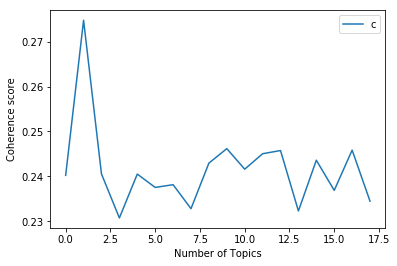

In [8]:
# Find the optimal number of topics
START = 10
LIMIT = 100
STEP = 5
topic_range = range(START, LIMIT, STEP)

coherence_values = []
model_list = []
for num_topics in topic_range:
    model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=train_df['caption_lemmatized'], 
                                                                 dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

max_coherence_val = 0
optimal_model = None

# Print the coherence scores
for i, (m, cv) in enumerate(zip(topic_range, coherence_values)):
    if max_coherence_val < round(cv, 4):
        optimal_model = model_list[i]
        optimal_num_topics = m
        max_coherence_val = round(cv, 4)

    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# plot coherence results
plt.plot(coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
# Print the Keyword in the 10 topics
for topic in optimal_model.print_topics():
    print(topic)
    
doc_lda = optimal_model[corpus]

(0, '0.045*"man" + 0.032*"stand" + 0.029*"woman" + 0.024*"dog" + 0.023*"people" + 0.019*"girl" + 0.018*"basketball" + 0.018*"sit" + 0.017*"wear" + 0.014*"rock"')
(1, '0.044*"man" + 0.044*"boy" + 0.028*"stand" + 0.026*"red" + 0.026*"wear" + 0.022*"little" + 0.020*"water" + 0.019*"child" + 0.016*"ride" + 0.016*"girl"')
(2, '0.064*"woman" + 0.062*"man" + 0.027*"wear" + 0.020*"sit" + 0.020*"black" + 0.018*"stand" + 0.017*"red" + 0.014*"young" + 0.013*"walk" + 0.013*"look"')
(3, '0.032*"man" + 0.027*"player" + 0.026*"woman" + 0.025*"black" + 0.022*"hold" + 0.018*"boy" + 0.018*"wear" + 0.016*"white" + 0.015*"look" + 0.013*"ball"')
(4, '0.104*"girl" + 0.027*"little" + 0.022*"wear" + 0.020*"young" + 0.018*"ride" + 0.016*"shirt" + 0.015*"hold" + 0.014*"walk" + 0.014*"pink" + 0.013*"boy"')
(5, '0.075*"people" + 0.030*"stand" + 0.029*"group" + 0.028*"sit" + 0.027*"man" + 0.025*"girl" + 0.021*"hold" + 0.020*"water" + 0.013*"woman" + 0.011*"young"')
(6, '0.080*"dog" + 0.041*"play" + 0.034*"run" + 0

In [10]:
print('Optimal Number of Topics :', optimal_num_topics)

# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=optimal_model, texts=data_caption_lemmatized, 
                                                                  dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Optimal Number of Topics : 15

Perplexity:  -6.108260669571425

Coherence Score:  0.27253590614098655


In [11]:
def predictTopics(corpus):

    caption_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(optimal_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = optimal_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                caption_topics_df = caption_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), 
                                                             ignore_index=True)
            else:
                break

    caption_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    return caption_topics_df
    
df = predictTopics([id2word.doc2bow(text) for text in train_df['caption_lemmatized']])
train_df = pd.concat([train_df.reset_index(drop=True), df], axis=1)

df = predictTopics([id2word.doc2bow(text) for text in valid_df['caption_lemmatized']])
valid_df = pd.concat([valid_df.reset_index(drop=True), df], axis=1)

df = predictTopics([id2word.doc2bow(text) for text in test_df['caption_lemmatized']])
test_df = pd.concat([test_df.reset_index(drop=True), df], axis=1)

In [12]:
# save the data object files
pickle.dump(train_df, open('./data/train_df.pkl','wb'))
pickle.dump(valid_df, open('./data/valid_df.pkl','wb'))
pickle.dump(test_df, open('./data/test_df.pkl','wb'))

In [4]:
# Load the data object files
optimal_num_topics = 15
train_df = pickle.load(open('./data/train_df.pkl', 'rb'))
valid_df = pickle.load(open('./data/valid_df.pkl', 'rb'))
test_df = pickle.load(open('./data/test_df.pkl', 'rb'))

### Model Building

In [5]:
# Create model
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

# pop the last softmax layer 
vgg16_model.layers.pop()

# freezing the remaining layers
for layer in vgg16_model.layers:
    layer.trainable = False

output_model = keras.layers.Dense(2056, activation='tanh')(vgg16_model.layers[-1].output)
output_model = keras.layers.Dropout(0.5)(output_model)
output_model = keras.layers.Dense(1024, activation='tanh')(output_model)
output_model = keras.layers.Dropout(0.5)(output_model)
output_model = keras.layers.Dense(optimal_num_topics, activation='softmax')(output_model)

vgg16_model = keras.models.Model(input = vgg16_model.input, output = output_model)            

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
vgg16_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\jsaikumar\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_paths, labels, image_dimensions=(224, 224, 3), batch_size=64, shuffle=False):
        self.labels       = labels              # array of labels
        self.images_paths = images_paths        # array of image paths
        self.image_dim = image_dimensions
        self.batch_size   = batch_size          # batch size
        self.shuffle      = shuffle             # shuffle bool

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images_paths) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # select data and load images
        labels = np.array([self.labels[k] for k in indexes])

        images = np.array([self.preprocessImageForVGG16(self.images_paths[k]) for k in indexes])
        
        return images, labels
    
    
    #customize function used for color convetion
    def preprocessImageForVGG16(self, filename):
        # load image
        image = keras.preprocessing.image.load_img(filename, target_size=(self.image_dim[0], self.image_dim[1]))
        # convert the image pixels to a numpy array
        image = keras.preprocessing.image.img_to_array(image)
        # prepare the image for the VGG model
        image = keras.applications.vgg16.preprocess_input(image)

        return image

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 1124s - loss: 2.8758 - acc: 0.2810 - val_loss: 2.0814 - val_acc: 0.2960

Epoch 00001: val_loss improved from inf to 2.08143, saving model to ./data/topic_predictor_model.hdf5
Epoch 2/20
 - 1124s - loss: 2.4388 - acc: 0.3275 - val_loss: 1.9954 - val_acc: 0.3850

Epoch 00002: val_loss improved from 2.08143 to 1.99535, saving model to ./data/topic_predictor_model.hdf5
Epoch 3/20
 - 1125s - loss: 2.3304 - acc: 0.3417 - val_loss: 2.1120 - val_acc: 0.3270

Epoch 00003: val_loss did not improve from 1.99535
Epoch 4/20
 - 1132s - loss: 2.2343 - acc: 0.3562 - val_loss: 1.9621 - val_acc: 0.3920

Epoch 00004: val_loss improved from 1.99535 to 1.96208, saving model to ./data/topic_predictor_model.hdf5
Epoch 5/20
 - 1127s - loss: 2.1636 - acc: 0.3642 - val_loss: 2.0286 - val_acc: 0.3740

Epoch 00005: val_loss did not improve from 1.96208
Epoch 6/20
 - 1125s - loss: 2.1164 - acc: 0.3792 - val_loss: 1.9569 - val_acc: 0.3890

Epoch 00006: v

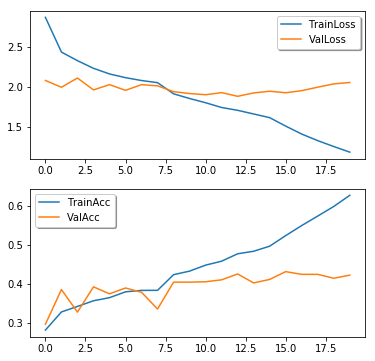

In [15]:
# Train the model
# reduces learning rate if no improvement are seen
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

# stop training if no improvements are seen
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",
                           mode="min",
                           patience=10)

# saves model weights to file
checkpoint = keras.callbacks.ModelCheckpoint('./data/topic_predictor_model.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True)


X_train = train_df['image_id'].values
Y_train = train_df['Dominant_Topic'].values
Y_train = keras.utils.to_categorical(Y_train, num_classes=optimal_num_topics)

X_valid = valid_df['image_id'].values
Y_valid = valid_df['Dominant_Topic'].values
Y_valid = keras.utils.to_categorical(Y_valid, num_classes=optimal_num_topics)


# prepare data generator
train_data = DataGenerator(X_train, Y_train, batch_size=50, shuffle=True)
valid_data = DataGenerator(X_valid, Y_valid, batch_size=50, shuffle=False)

# train on data
history = vgg16_model.fit_generator(generator=train_data,
                                   validation_data=valid_data,
                                   epochs=20,
                                   steps_per_epoch=len(train_data),
                                   validation_steps =len(valid_data),
                                   callbacks=[learning_rate_reduction, early_stop, checkpoint],
                                   verbose=2,
                                   )

# plot training history
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="TrainLoss")
ax[0].plot(history.history['val_loss'], label="ValLoss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], label="TrainAcc")
ax[1].plot(history.history['val_acc'], label="ValAcc")
ax[1].legend(loc='best', shadow=True)
plt.show()  

In [7]:
vgg16_model.load_weights('./data/topic_predictor_model.hdf5')

X_test = test_df['image_id'].values
Y_test = test_df['Dominant_Topic'].values
Y_test = keras.utils.to_categorical(Y_test, num_classes=optimal_num_topics)

# prepare data generator
test_data = DataGenerator(X_test, Y_test, batch_size=1, shuffle=False)

# predict on data
pred_caption_topics_prob = vgg16_model.predict_generator(test_data)
pred_caption_topics = np.argmax(pred_caption_topics_prob, axis=1)

results_df = pd.DataFrame({ 'image_id':X_test, 'pred_topics':pred_caption_topics })
results_df.head()

,image_id,pred_topics
0,./data/Flicker8k_Dataset/3717845800_ab45e255b8...,11
1,./data/Flicker8k_Dataset/3718007650_e5930b4509...,2
2,./data/Flicker8k_Dataset/3718076407_0b4588d7bc...,7
3,./data/Flicker8k_Dataset/3718305988_fe2c91fd44...,7
4,./data/Flicker8k_Dataset/3718892835_a3e74a3417...,2


In [8]:
# Evaluation score
log_score = sklearn.metrics.log_loss(test_df['Dominant_Topic'].values, pred_caption_topics_prob)
print('Log-loss score :', log_score)

acc_score = sklearn.metrics.accuracy_score(test_df['Dominant_Topic'].values, pred_caption_topics)
print('Accuracy score :', acc_score)

print('Confusion matrix :')
print(sklearn.metrics.confusion_matrix(test_df['Dominant_Topic'].values, pred_caption_topics))

Log-loss score : 1.607366663068533
Accuracy score : 0.532
Confusion matrix :
[[ 25   0   7   1   3   2   1   2   5   0   0   1   0   2   3]
 [  3   9   4   1   1   1   2   2   7   0   0   1   0  26   1]
 [  1   1  83   0   3   6   2   3   8   0   0   0   0   9   1]
 [  0   0   5   2   0   0   1   0   4   0   0   1   0   1   0]
 [  2   0   9   0   8   2   5   2   2   0   0   2   1  11   0]
 [  1   0  22   1   2  16   2   1   5   0   0   3   0   5   5]
 [  0   0  10   0   1   3  17  15   3   0   0   1   0   9   0]
 [  1   1   2   0   0   1   4 261   0   0   0   1   0   3   1]
 [  1   0   5   0   0   3   1   3   8   0   0   0   0   5   0]
 [  1   0  36   0   1   3   2   0   4   0   0   0   0   8   1]
 [  0   0   0   1   0   0   2   4   2   0   0   1   0   1   0]
 [  3   2   9   0   0   0   0   5   5   0   0   4   0   3   0]
 [  2   0  11   1   0   0   1   1   1   0   0   0   0   0   0]
 [  1   3   7   0   6   4  14   5   9   0   0   0   0  80   0]
 [  4   2   9   1   0   1   1   3   5   0